# 👣 Track the coupled fields between CICE6 and WW3

In [1]:
import intake
from intake import cat
# from datatree import DataTree, map_over_subtree

from dask.distributed import Client
import glob
import xarray as xr
import numpy as np
from datetime import timedelta
import cf_xarray as cfxr
import xesmf
import re

# plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean.cm as cmo
import matplotlib.lines as mlines
import cartopy.feature as cft
import seaborn as sns
from cycler import cycler

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
from attenuation_models import *
test()

colors = sns.color_palette("colorblind")
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)
𝜋 = np.pi
PUNY = 1e-11

Functions from get_files.py imported!


In [3]:
ATTEN_OPT = "IC4M2"
EXPT = f"IC4-{ATTEN_OPT}-MCW_100km_jra_iaf-uncoupled" #"IC4-IC4M2-MCW_100km_jra_iaf-update"
drive = "scratch" # g/data or scratch
run_dir = "archive" # archive or work

if run_dir == "archive":
    # PATH = f"/{drive}/ps29/nd0349/access-om3/{run_dir}/{EXPT}/output00*"
    if drive == "scratch":
        PATH = f"/{drive}/ps29/nd0349/access-om3/archive/{EXPT}/output00*"
    else:
        PATH = f"/{drive}/ps29/nd0349/access-om3/runs/archive/{EXPT}/output00*"
else:
    PATH = f"/{drive}/ps29/nd0349/access-om3/{run_dir}/{EXPT}"
PATH
# /scratch/ps29/nd0349/access-om3/archive/IC4-IC4M2-MCW_100km_jra_iaf-update

'/scratch/ps29/nd0349/access-om3/archive/IC4-IC4M2-MCW_100km_jra_iaf-uncoupled/output00*'

In [4]:
from pathlib import Path

cice_files = sorted(glob.glob(f"{PATH}/access-om3.cice.1*.nc"))#[::30]
# cice_files = sorted(glob.glob(f"{PATH}/access-om3.cice_inst*.nc"))
ds_cice = xr.open_mfdataset(cice_files,
                            combine='by_coords',
                            data_vars='minimal',
                            coords='minimal',
                            compat='override'
                           )
ds_cice.attrs['intake_esm_attrs:realm'] = "ice"
grid_ds = xr.open_dataset('/g/data/vk83/configurations/inputs/access-om3/cice/grids/global.1deg/2024.05.14/grid.nc')
ds_cice.coords['TLON'] = np.degrees(grid_ds['tlon'])
ds_cice.coords['TLAT'] = np.degrees(grid_ds['tlat'])
ds_cice['tarea'] = np.degrees(grid_ds['tarea'])

ww3_files = sorted(glob.glob(f"{PATH}/access-om3.ww3.*.nc"))#[::100]
ds_ww3 = xr.open_mfdataset(ww3_files,
                        combine='by_coords',
                        data_vars='minimal',
                        coords='minimal',
                        compat='override'
                        )
ds_ww3.coords['lon'] = ds_ww3['lon']
ds_ww3.coords['lat'] = ds_ww3['lat']
ds_ww3.attrs['intake_esm_attrs:realm'] = "wave"
ds_ww3

<xarray.Dataset> Size: 524MB
Dimensions:  (ny: 300, nx: 360, time: 31, freq: 25)
Coordinates:
    lon      (ny, nx) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat      (ny, nx) float64 864kB dask.array<chunksize=(300, 360), meta=np.ndarray>
  * time     (time) datetime64[ns] 248B 1958-01-02 1958-01-03 ... 1958-02-01
Dimensions without coordinates: ny, nx, freq
Data variables: (12/15)
    mapsta   (time, ny, nx) int32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    UAX      (time, ny, nx) float32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    UAY      (time, ny, nx) float32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICE      (time, ny, nx) float32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEH     (time, ny, nx) float32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ICEF     (time, ny, nx) float32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    ...       ...
    T01      (time, ny, nx) float32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    FP0      (time, ny, nx) float32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    THM      (time, ny, nx) float32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    EF       (time, freq, ny, nx) float32 335MB dask.array<chunksize=(1, 25, 300, 360), meta=np.ndarray>
    USSX     (time, ny, nx) float32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    USSY     (time, ny, nx) float32 13MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes:
    intake_esm_attrs:realm:  wave

## Check that time is progressing as it should be

CICE:
  Start: 1958-01-01T12:00:00.000000000
  End:   1958-01-31T12:00:00.000000000
  Length: 31 steps
  Mean Δt: 24.00 hours
  Unique Δt: [24.] hours

WW3:
  Start: 1958-01-02T00:00:00.000000000
  End:   1958-02-01T00:00:00.000000000
  Length: 31 steps
  Mean Δt: 24.00 hours
  Unique Δt: [24.] hours



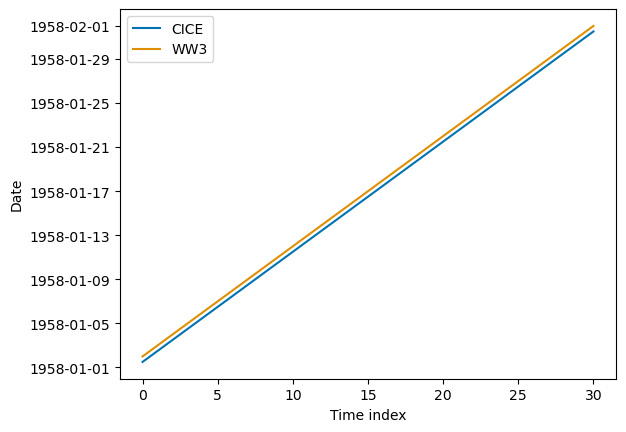

In [5]:
def describe_time_axis(name, time):
    diffs = np.diff(time.values).astype('timedelta64[h]').astype(float)
    print(f"{name}:")
    print(f"  Start: {time.values[0]}")
    print(f"  End:   {time.values[-1]}")
    print(f"  Length: {len(time)} steps")
    print(f"  Mean Δt: {np.mean(diffs):.2f} hours")
    print(f"  Unique Δt: {np.unique(diffs)} hours")
    print()

describe_time_axis("CICE", ds_cice.time)
describe_time_axis("WW3", ds_ww3.time)


plt.plot(ds_cice.time, label='CICE')
plt.plot(ds_ww3.time, label='WW3')
plt.xlabel('Time index')
plt.ylabel('Date')
plt.legend()

In [69]:
# ds_ww3.time.values
ds_cice

<xarray.Dataset> Size: 4GB
Dimensions:      (time: 31, nbnd: 2, nkice: 4, nksnow: 1, nkbio: 3, nkaer: 5,
                  nj: 300, ni: 360, nf: 12, nc: 5)
Coordinates:
  * time         (time) datetime64[ns] 248B 1958-01-01T12:00:00 ... 1958-01-3...
    NCAT         (nc) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    ulat         (nj, ni) float64 864kB ...
    ulon         (nj, ni) float64 864kB ...
    tlat         (nj, ni) float64 864kB -1.359 -1.359 -1.359 ... 1.145 1.138
    tlon         (nj, ni) float64 864kB -4.878 -4.861 -4.843 ... 1.396 1.396
    TLON         (nj, ni) float64 864kB -279.5 -278.5 -277.5 ... 79.97 79.99
    TLAT         (nj, ni) float64 864kB -77.88 -77.88 -77.88 ... 65.63 65.21
Dimensions without coordinates: nbnd, nkice, nksnow, nkbio, nkaer, nj, ni, nf,
                                nc
Data variables: (12/34)
    time_bounds  (time, nbnd) datetime64[ns] 496B dask.array<chunksize=(1, 2), meta=np.ndarray>
    VGRDi        (nkice) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
    VGRDs        (nksnow) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    VGRDb        (nkbio) float64 24B dask.array<chunksize=(3,), meta=np.ndarray>
    VGRDa        (nkaer) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    blkmask      (nj, ni) float64 864kB dask.array<chunksize=(150, 180), meta=np.ndarray>
    ...           ...
    dafsd_latg   (time, nf, nj, ni) float64 321MB dask.array<chunksize=(1, 12, 150, 180), meta=np.ndarray>
    dafsd_latm   (time, nf, nj, ni) float64 321MB dask.array<chunksize=(1, 12, 150, 180), meta=np.ndarray>
    dafsd_wave   (time, nf, nj, ni) float64 321MB dask.array<chunksize=(1, 12, 150, 180), meta=np.ndarray>
    dafsd_weld   (time, nf, nj, ni) float64 321MB dask.array<chunksize=(1, 12, 150, 180), meta=np.ndarray>
    afsdn        (time, nc, nf, nj, ni) float64 2GB dask.array<chunksize=(1, 3, 6, 150, 180), meta=np.ndarray>
    tarea        (nj, ni) float64 864kB 3.672e+10 3.672e+10 ... 2.2e+09
Attributes: (12/14)
    title:                   access-om3
    contents:                Diagnostic and Prognostic Variables
    source:                  CICE Sea Ice Model, unknown_version_name
    comment:                 This year has 365 days
    comment2:                File written on model date 19580102
    comment3:                seconds elapsed into model date:      0
    ...                      ...
    Conventions:             CF-1.8
    external_variables:       TLON TLAT ULON ULAT NLON NLAT ELON ELAT NFSD tm...
    history:                 This dataset was created on 2025-10-21 at 16:21
    date_created:            2025-10-21 16:21
    io_flavor:               io_pio2 hdf5
    intake_esm_attrs:realm:  ice

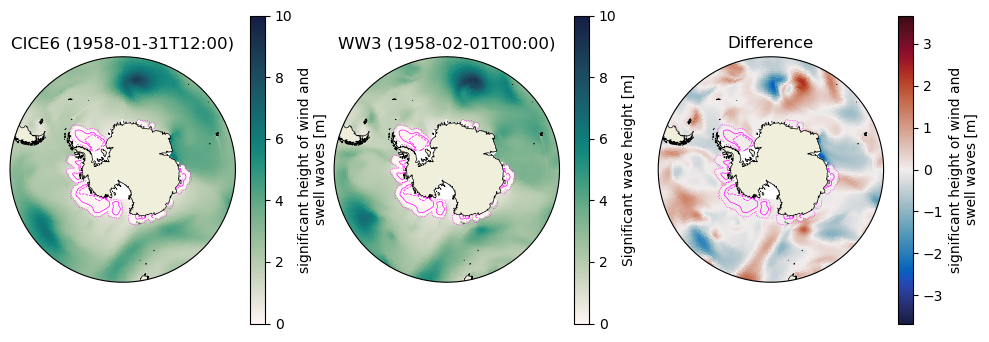

In [70]:
time_idx = -1
hemisphere="south"
ds_plot_cice = ds_cice.isel(time=time_idx)
ds_plot_ww3 = ds_ww3.isel(time=time_idx)

ww3_vars_dict = {
    "aice": "ICE",
    "wave_sig_ht": "HS",
    "fsdrad": "ICEF",
    "hi": "ICEH",
    "TLON": "lon",
    "TLAT": "lat"
}

var = 'wave_sig_ht'

proj = ccrs.SouthPolarStereo()
dims = [1,3]
fig, axes, projection = basic_axis(dims)

settings = get_plot_settings(var)

ds_plot_cice[var].plot(ax=axes[0], x="TLON", y="TLAT", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 

ds_plot_ww3 = ds_ww3.isel(time=time_idx)
ds_plot_ww3[ww3_vars_dict[var]].plot(ax=axes[1], x="lon", y="lat", 
                        cmap=settings.get("cmap"),
                        vmin=settings.get("vmin"),
                        vmax=settings.get("vmax"),
                        transform=ccrs.PlateCarree(),
) 

difference = ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var].values
ds_plot_cice[f'diff_{var}'] = ds_plot_cice[var]
ds_plot_cice[f'diff_{var}'].values = difference
ds_plot_cice[f'diff_{var}'].plot(ax=axes[2], x="TLON", y="TLAT", 
                        cmap=cmo.balance,
                        transform=ccrs.PlateCarree(),
) 


# --- Add ice contours ---
for ax in axes:
    add_ice_contours(ax, ds_plot_cice, hemisphere, projection)

# --- Add titles ---
time_str = str(ds_plot_cice['time'].values)[:16]  # Trim to readable format
axes[0].set_title(f"CICE6 ({time_str})")
time_str = str(ds_plot_ww3['time'].values)[:16]  # Trim to readable format
axes[1].set_title(f"WW3 ({time_str})")
axes[2].set_title("Difference")

fig.savefig(f"/home/566/nd0349/access-om3-analysis/figures/track_coupled_fields/{str(ds_plot_ww3['time'].values)[:10]}_{var}.png", dpi=300, bbox_inches='tight')
plt.show()


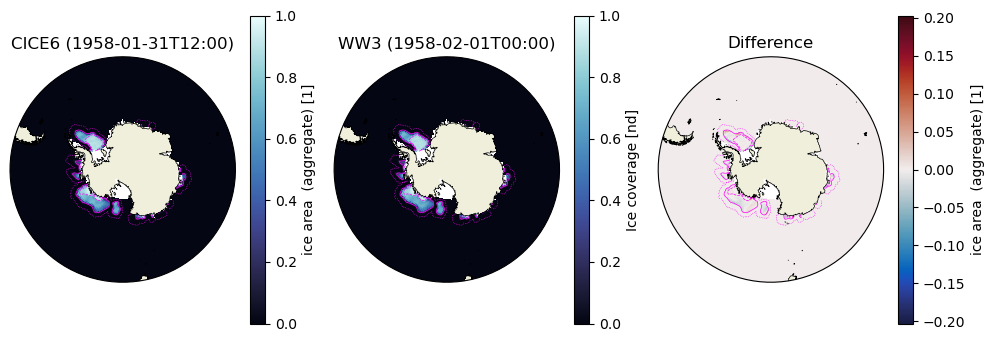

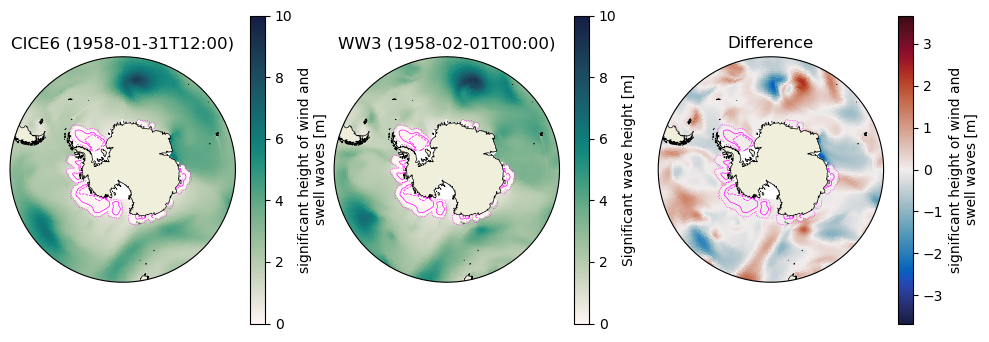

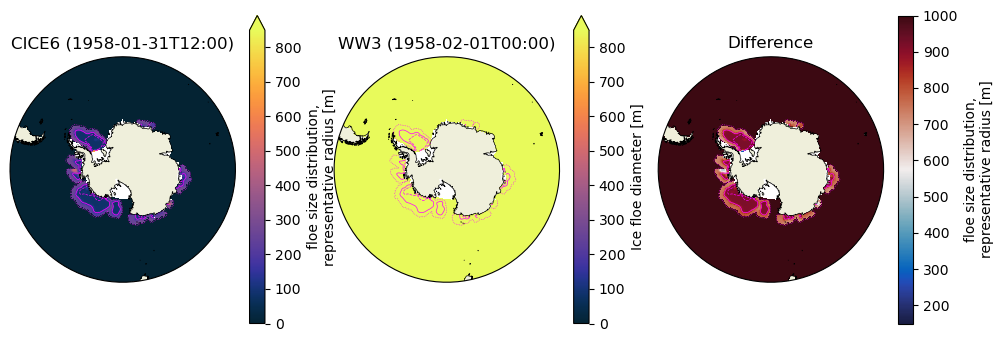

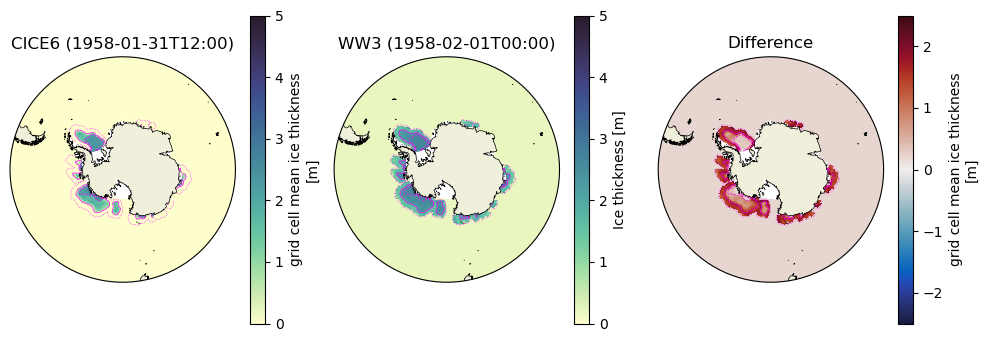

In [71]:
# time_idx = 100

ds_plot_cice = ds_cice.isel(time=time_idx)
ds_plot_ww3 = ds_ww3.isel(time=time_idx)

ww3_vars_dict = {
    "aice": "ICE",
    "wave_sig_ht": "HS",
    "fsdrad": "ICEF",
    "hi": "ICEH",
    "TLON": "lon",
    "TLAT": "lat"
}

for var in ["aice", "wave_sig_ht", "fsdrad", "hi"]:
    proj = ccrs.SouthPolarStereo()
    dims = [1,3]
    fig, axes, projection = basic_axis(dims)
    
    settings = get_plot_settings(var)
    
    ds_plot_cice[var].plot(ax=axes[0], x="TLON", y="TLAT", 
                            cmap=settings.get("cmap"),
                            vmin=settings.get("vmin"),
                            vmax=settings.get("vmax"),
                            transform=ccrs.PlateCarree(),
    ) 
    
    ds_plot_ww3 = ds_ww3.isel(time=time_idx)
    ds_plot_ww3[ww3_vars_dict[var]].plot(ax=axes[1], x="lon", y="lat", 
                            cmap=settings.get("cmap"),
                            vmin=settings.get("vmin"),
                            vmax=settings.get("vmax"),
                            transform=ccrs.PlateCarree(),
    ) 
    
    difference = ds_plot_ww3[ww3_vars_dict[var]].values - ds_plot_cice[var].values
    ds_plot_cice[f'diff_{var}'] = ds_plot_cice[var]
    ds_plot_cice[f'diff_{var}'].values = difference
    ds_plot_cice[f'diff_{var}'].plot(ax=axes[2], x="TLON", y="TLAT", 
                            cmap=cmo.balance,
                            transform=ccrs.PlateCarree(),
    ) 
    
    
    # --- Add ice contours ---
    for ax in axes:
        add_ice_contours(ax, ds_plot_cice, hemisphere, projection)
    
    # --- Add titles ---
    time_str = str(ds_plot_cice['time'].values)[:16]  # Trim to readable format
    axes[0].set_title(f"CICE6 ({time_str})")
    time_str = str(ds_plot_ww3['time'].values)[:16]  # Trim to readable format
    axes[1].set_title(f"WW3 ({time_str})")
    axes[2].set_title("Difference")
    
    fig.savefig(f"/home/566/nd0349/access-om3-analysis/figures/track_coupled_fields/{str(ds_plot_ww3['time'].values)[:10]}_{var}.png", dpi=300, bbox_inches='tight')
    plt.show()
